In [127]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("figures.mplstyle")
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon

import shapely

# Function and class def|intions for defining LHC/Lake geometry
from GeometryHelpers import *

In [6]:
LHC_data = pd.read_parquet('Data/LHC_data.parquet')
Lake_data = pd.read_parquet('Data/Lake_data.parquet')

# Define the LHC circle
LHC = Circle(np.array(LHC_data.loc['Point4',['X','Y','Z']]),
             np.array(LHC_data.loc['LHCb',['X','Y','Z']]),
             np.array(LHC_data.loc['Point6',['X','Y','Z']])) # last entry can be Point 2 or 6

# Fix elevation of other LHC interaction points based on LHC circle definition
for k in list(LHC_data.index):
    elev,point = LHC.find_elevation(*np.array(LHC_data.loc[k,['Latitude','Longitude']]))
    LHC_data['Elevation'][k] = elev
    LHC_data.loc[k,['X','Y','Z']] = lat_long_to_xyz(*LHC_data.loc[k,['Latitude','Longitude','Elevation']])

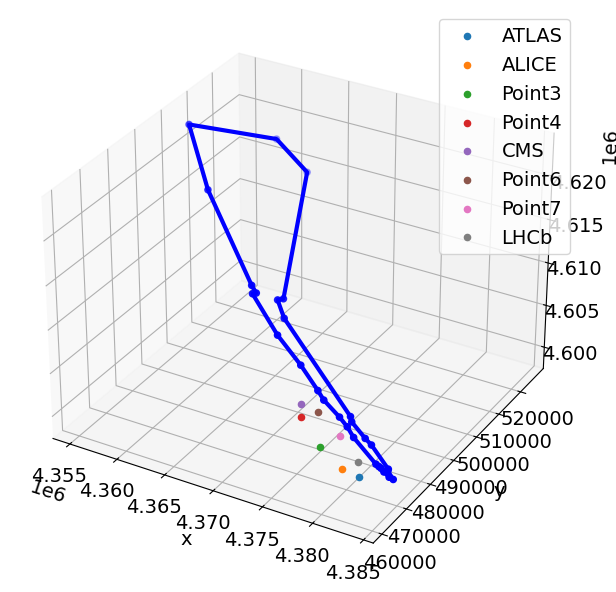

In [7]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')
for k in list(LHC_data.index):
    ax.scatter(*LHC_data.loc[k,['X','Y','Z']])
ax.scatter(*np.array(Lake_data[['X','Y','Z']]).transpose(),color='blue')
# for point in Lake_data[['X','Y','Z']]:
#     ax.scatter(*point,color='blue')
ax.plot(np.append(Lake_data['X'],Lake_data['X'][0]),
        np.append(Lake_data['Y'],Lake_data['Y'][0]),
        zs=np.append(Lake_data['Z'],Lake_data['Z'][0]),
        color='blue')
plt.legend(list(LHC_data.index))
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

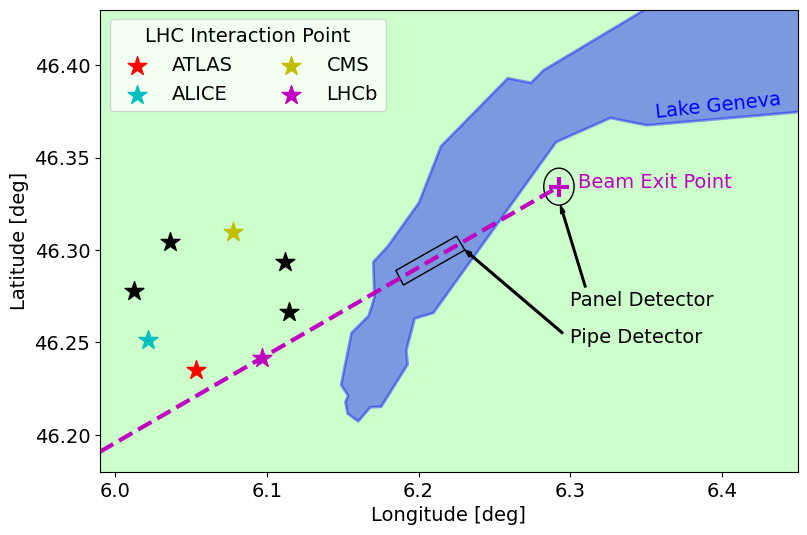

In [214]:
fig = plt.figure(figsize=(9,6))
ax = plt.gca()
ax.set_facecolor((0,1,0,0.2))
plt.fill(list(Lake_data['Longitude']) + [Lake_data['Longitude'][0]],
         list(Lake_data['Latitude']) + [Lake_data['Latitude'][0]],
         color='blue',alpha=0.4,linewidth=2)
Lake_Crossings = {}
color_count = 0
colors = ["r","c","y","m"]
for k in list(LHC_data.index):
    if "Point" in k: color = "black"
    else:
        color = colors[color_count]
        color_count+=1
    Lake_Crossings[k] = []
    lines = plot_tangent_line_lat_long(LHC,
                                       np.array(LHC_data.loc[k,['X','Y','Z']]),
                                       np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                       limit=1 if 'LHCb' not in k else 18000)
    center, earth_points = lines[0] # all lines are essentially the same
    plt.plot([p[1] for p in earth_points],
            [p[0] for p in earth_points],color=color,ls='--')
    plt.scatter(center[1],
                center[0],
                marker='*',s=200,color=color,label=k if not "Point" in k else None)
    if 'Point' in k: continue # don't consider points without collisions
    if k!="LHCb": continue
    int1,int2 = calculate_intersections_with_lake(LHC,
                                                np.array(LHC_data.loc[k,['X','Y','Z']]),
                                                np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                                np.array(Lake_data[['Latitude','Longitude']]),
                                                limit=50000000)
    for intersections in (int1,int2):
        if(type(intersections) == shapely.geometry.MultiLineString):
            for intersection in intersections.geoms:
                for coord in list(intersection.coords):
                    Lake_Crossings[k].append(coord)
        else:
            for coord in list(intersections.coords):
                Lake_Crossings[k].append(coord)
    # for coord in Lake_Crossings[k]:
    #     plt.scatter(coord[1],coord[0],color=color)
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
plt.legend(loc='upper left',ncol=2,title="LHC Interaction Point")
beam_exit = (6.292559636631747,46.33426874901515)
plt.scatter(*beam_exit,marker='+',facecolors=colors[-1],s=200)
plt.text(1.002*6.292559636631747,0.99999*46.33426874901515,'Beam Exit Point',
         color=colors[-1],fontsize=14)
plt.text(1.01*6.292559636631747,1.0008*46.33426874901515,'Lake Geneva',
         color="blue",fontsize=14,rotation=6)
pts = np.array([[6.19,46.281],[6.185,46.2889],[6.225,46.3075],[6.2305,46.3]])
rectangle = Polygon(pts,edgecolor="black",facecolor="none")
plt.arrow(6.295,46.255,pts[3][0]-6.295,pts[3][1]-46.255,length_includes_head=True,color="black")
plt.text(6.3,46.25,"Pipe Detector",fontsize=14)
plt.gca().add_patch(rectangle)
circle = plt.Circle(beam_exit,0.01, fc='none',ec="black")
plt.arrow(6.31,46.28,beam_exit[0]-6.309,beam_exit[1]-46.29,length_includes_head=True,color="black")
plt.text(6.3,46.27,"Panel Detector",fontsize=14)
plt.gca().add_patch(circle)
plt.xlim(5.99,6.45)
plt.ylim(46.18,46.43)
plt.savefig("GeometryDiagram.pdf",dpi=100)
plt.show()

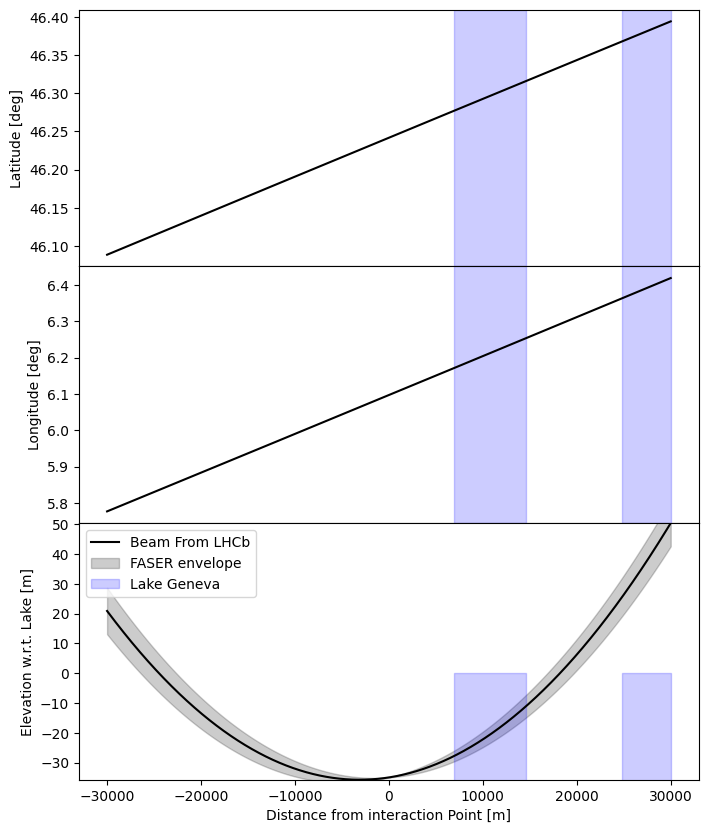

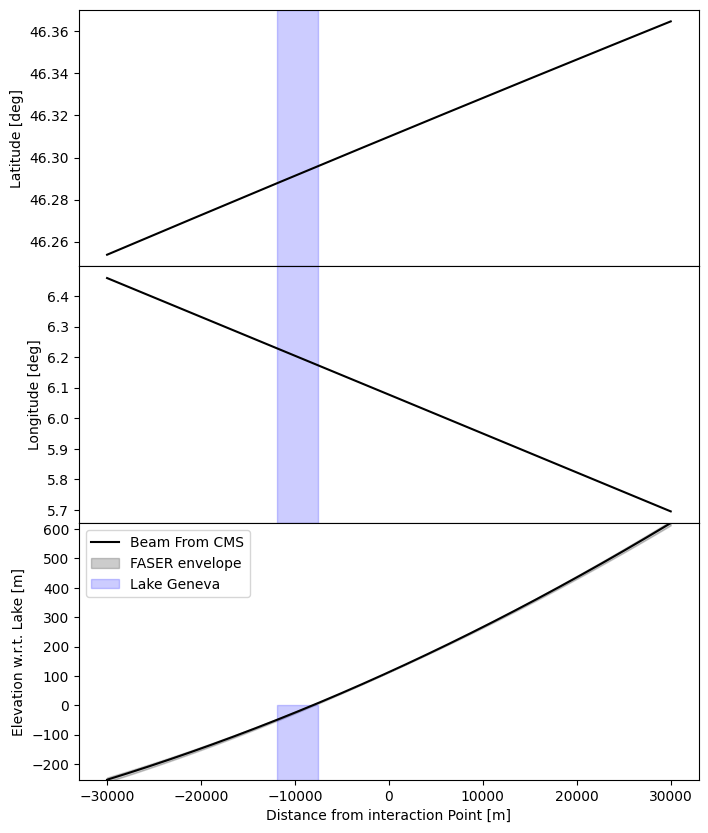

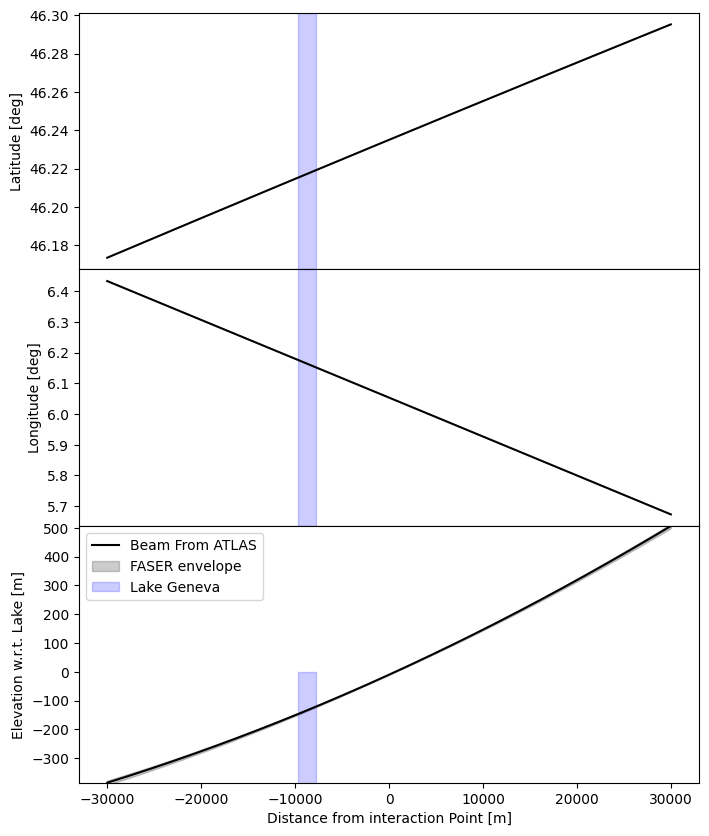

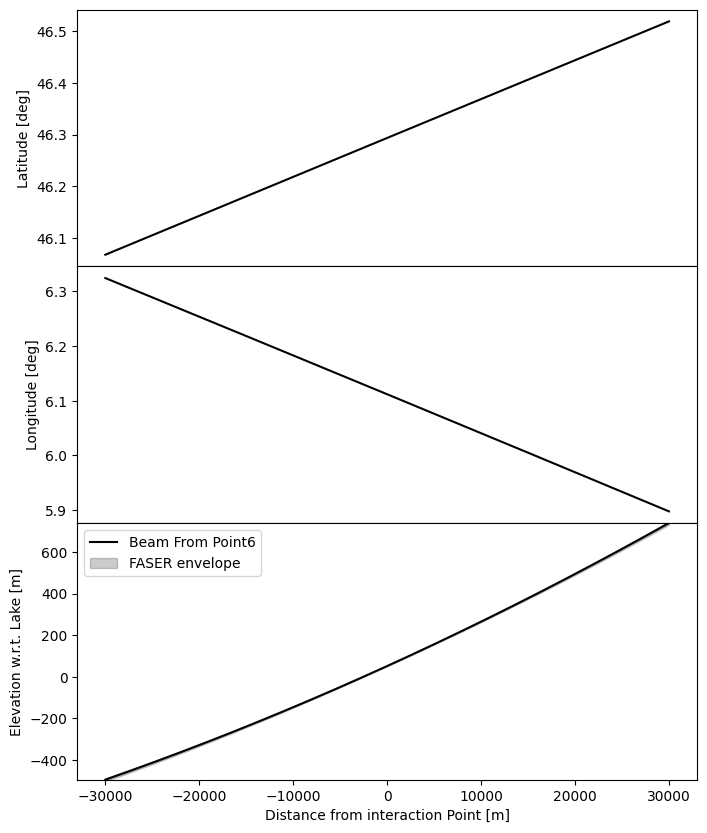

In [5]:
for k in ['LHCb','CMS','ATLAS','Point6']:
    plot_tangent_line(LHC,
                      np.array(LHC_data.loc[k,['X','Y','Z']]),
                      np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                      limit=30000,
                      Lake_Crossings=Lake_Crossings[k],
                      label='Beam From %s'%k)
    plt.show()

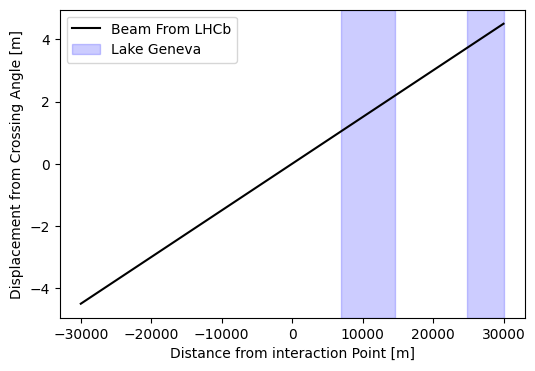

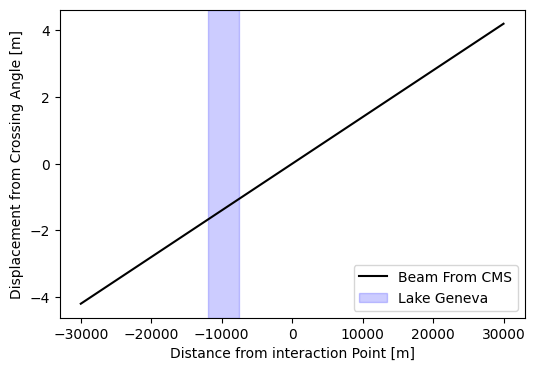

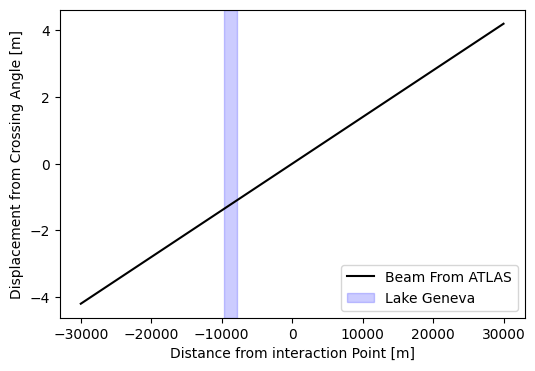

In [6]:
for k in ['LHCb','CMS','ATLAS']:
    plot_crossing_angle_impact(LHC,
                               np.array(LHC_data.loc[k,['X','Y','Z']]),
                               np.array(LHC_data.loc[k,['CrossingAngle']])/2.,
                               limit=30000,
                               Lake_Crossings=Lake_Crossings[k],
                               label='Beam From %s'%k)
    plt.show()